# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBINS = 1000
SIGMA = 0.01

In [ ]:
# A toy model with a diffuse and point source component

def model(z, sigma = SIGMA, w = 0.4):
    x = z + np.random.randn(2)*sigma + (np.random.rand(2)-0.5)*w
    return x

In [ ]:
z0 = np.array([0.5, 0.5])
x0 = np.array([0.5, 0.5])

In [5]:
ds = swyft.DataStoreZarr("/home/ubuntu/volume1/zzzz1")
ds.init(zdim = 2, xdim = (2,))

Loading datastore: /home/ubuntu/volume1/zzzz1


In [6]:
# Instantiate network
sw = swyft.SWYFT(x0, model, zdim = 2, device = DEVICE, head = None, datastore = ds)

In [7]:
sw.advance_train_history(nsamples = 1000)

Constrained posterior area: 1.0
No new simulator runs required.


In [8]:
if sw.requires_sim():
    for i in ds.require_sim():
        z = ds.z[i]
        x = model(z)
        ds.add_sim(i, x)

In [9]:
sw.advance_net1d_history()

In [10]:
sw.train1d(max_epochs = 1, nbatch = 32)

Start training
LR iteration 0
Total epochs: 1
Validation losses: [5.313404738903046]
LR iteration 1
Total epochs: 1
Validation losses: [5.235398292541504]
LR iteration 2
Total epochs: 1
Validation losses: [5.2269273698329926]


In [11]:
sw.advance_post1d_history()

In [12]:
print(len(sw.train_history), len(sw.net1d_history), len(sw.post1d_history))

1 1 1


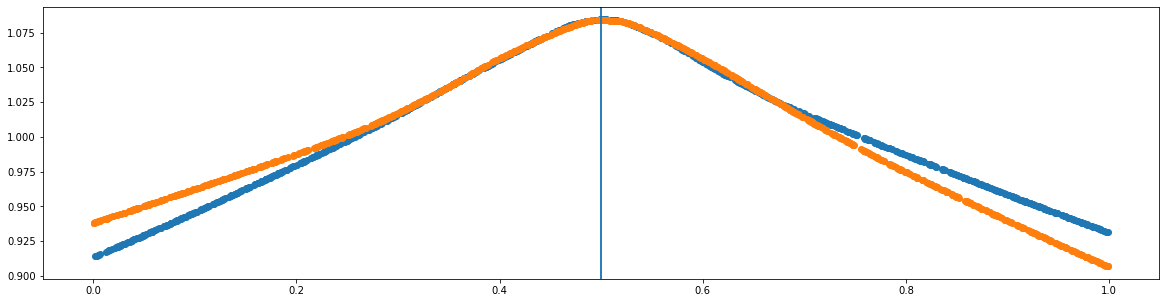

In [13]:
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw.posterior(i)
    plt.axvline(z0[i])
    plt.scatter(z, p)

In [14]:
sw.advance_train_history(nsamples = 10000)

Constrained posterior area: 1.0
No new simulator runs required.


In [15]:
if sw.requires_sim():
    for i in ds.require_sim():
        z = ds.z[i]
        x = model(z)
        ds.add_sim(i, x)

In [16]:
sw.advance_net1d_history()

In [17]:
sw.train1d(max_epochs = 1, nbatch = 32)

Start training
LR iteration 0
Total epochs: 1
Validation losses: [3.1493748277425766]
LR iteration 1
Total epochs: 1
Validation losses: [3.040973737835884]
LR iteration 2
Total epochs: 1
Validation losses: [3.0395373702049255]


In [18]:
sw.advance_post1d_history()

In [19]:
print(len(sw.train_history), len(sw.net1d_history), len(sw.post1d_history))

2 2 2


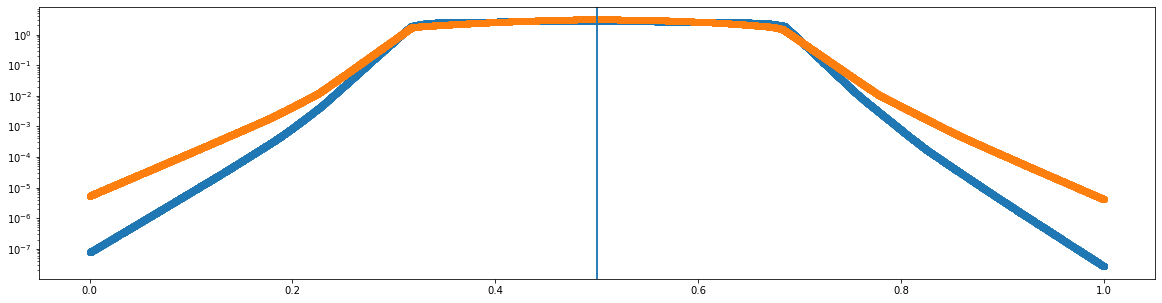

In [20]:
plt.figure(figsize=(20, 5))
for i in range(2):
    z, p = sw.posterior(i, version = -1)
    plt.axvline(z0[i])
    plt.scatter(z, p)
plt.gca().set_yscale('log')

In [41]:
def add_netNd(self, combinations, recycle_net = False):
    """Generate N-dim posteriors."""
    # Use by default data from last 1-dim round
    dataset = self.get_dataset(version = -1)
    datanorms = swyft.get_norms(dataset, combinations = combinations)
    
    # Generate network
    pnum = len(combinations)
    pdim = len(combinations[0])

    if recycle_net:
        head = deepcopy(self.net1d_history[-1].head)
        net = self._get_net(pnum, pdim, head = head, datanorms = datanorms)
    else:
        net = self._get_net(pnum, pdim, datanorms = datanorms)
        
    self.netNd_history.append(dict(net=net, combinations=combinations))

In [42]:
add_netNd(sw, [[0, 1], [0, 1], [0, 1]])

In [43]:
sw.trainNd(max_epochs = 1)

Start training
LR iteration 0
Total epochs: 1
Validation losses: [3.093988360837102]
LR iteration 1
Total epochs: 1
Validation losses: [2.705507460050285]
LR iteration 2
Total epochs: 1
Validation losses: [2.697141249664128]


In [45]:
def add_postNd(self):
    # Get posteriors and store them internally
    net = self.netNd_history[-1]['net']
    combinations = self.netNd_history[-1]['combinations']
    dataset = self.get_dataset(version = -1)
    
    zgrid, lnLgrid = swyft.posteriors(self.x0, net, dataset, combinations =
            combinations, device = self.device)

    self.postNd_history.append((combinations, zgrid, lnLgrid))

In [46]:
add_postNd(sw)

(0.0, 1.0)

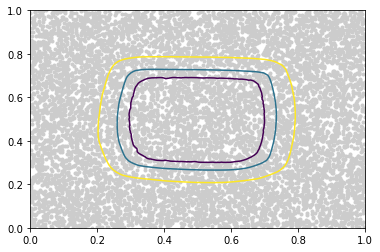

In [47]:
zgrid, lnLgrid = sw.posterior([0, 1])
plt.scatter(zgrid[:,0], zgrid[:,1], marker='.', color='0.8')
max_lnL = lnLgrid[:].max()
plt.tricontour(zgrid[:,0], zgrid[:,1], -lnLgrid+max_lnL, levels = [1, 4, 9])
plt.xlim([0, 1])
plt.ylim([0, 1])